In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from sklearn.pipeline import Pipeline
import category_encoders as ce

import sys
sys.path.insert(1, '../')

from src import preprocessing as pp
from src import analysis

# Enable module reloading
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

In [2]:
from sklearn.base import TransformerMixin
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Data preprocessing

In this notebook, we are going to preprocess our data, so we can use them during training.

## Load datasets

In [3]:
books = pd.read_csv('../data/books.csv')
reviews = pd.read_csv('../data/reviews.csv')
# intr = pd.read_csv('../data/interactions.csv')
authors = pd.read_csv('../data/authors.csv')

## Merge data

In [4]:
data = pd.merge(books, reviews , on='book_id')

In [5]:
data.head(3)

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series,user_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,NaN,1,['147734'],US,NaN,"[{'count': '1057', 'name': 'to-read'}, {'count...",B0056A00P4,True,4.04,B0056A00P4,"['519546', '1295074', '21407416']",This is the final tale in the bestselling auth...,NaN,https://www.goodreads.com/book/show/12182387-t...,"[{'author_id': '50873', 'role': ''}, {'author_...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/12182387-t...,https://s.gr-assets.com/assets/nophoto/book/11...,12182387,4,285263,"The Passion (Dark Visions, #3)","The Passion (Dark Visions, #3)",8a6085f339853bb493a8341f0d7e3bdf,fc61f4a89afd084140b9ea2090e552e2,5,Nachdem Gabriel und Lydia verschwunden sind un...,Fri Sep 09 12:32:42 -0700 2011,Wed Oct 26 11:11:47 -0700 2011,Tue Oct 25 00:00:00 -0700 2011,Sun Oct 23 00:00:00 -0700 2011,0,0
1,NaN,2,['425995'],US,NaN,"[{'count': '1010', 'name': 'to-read'}, {'count...",B006KLYIAG,True,3.80,B006KLYIAG,"['13400912', '13327517', '18107102', '15797097...",Life should be simple for Cassie.\nFor the sma...,NaN,https://www.goodreads.com/book/show/20135365-h...,"[{'author_id': '5395324', 'role': ''}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/20135365-h...,https://s.gr-assets.com/assets/nophoto/book/11...,20135365,5,18450480,Hope's Daughter,Hope's Daughter,c7cafc5c262441aaa9fc8c816dcd20d5,9f5ee0e6211043932bcb46793222c2f6,4,I received this book from the author in exchan...,Wed Apr 04 11:09:28 -0700 2012,Thu Mar 20 11:44:09 -0700 2014,Thu Mar 20 11:44:09 -0700 2014,Wed Mar 19 00:00:00 -0700 2014,2,0
2,0698143760,17,['493993'],US,NaN,"[{'count': '1799', 'name': 'fantasy'}, {'count...",NaN,True,3.80,NaN,"['15728807', '17182499', '15673520', '16081758...",Wanted by no one.\nHunted by everyone.\nSixtee...,ebook,https://www.goodreads.com/book/show/21401181-h...,"[{'author_id': '7314532', 'role': ''}]",Viking Children's,416.0,4.0,9780698143760,3.0,NaN,2014.0,https://www.goodreads.com/book/show/21401181-h...,https://images.gr-assets.com/books/1394747643m...,21401181,33,24802827,"Half Bad (Half Life, #1)","Half Bad (Half Life, #1)",88d99966e16ad22b3d824758e41bdc31,d1c5a076f2433511b239dd4745d88f99,4,Dark story about a young soon to be witch boy....,Fri Mar 24 04:36:25 -0700 2017,Mon Mar 27 13:28:45 -0700 2017,Mon Mar 27 13:28:45 -0700 2017,Fri Mar 24 04:36:26 -0700 2017,0,0


## Train/Test split

In [6]:
drop_cols = ['rating']

X = data.drop(drop_cols, axis=1)

In [7]:
y = data['rating']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Create preprocessing pipeline

### books
In this section, we will try to preprocess data from book dataset.

Problems needed to be solved by preprocessing are:
- drop columns that does not contain any useful information for our task (these are also columns that contain most of the missing values)
- replace authors columns with the average rating of authors
- export shelves (by default 'favorites', 'currently-reading', 'to-read', or any other) with number of votes
- normalize and scale the numeric atributes

### Reviews

In this section, we will try to preprocess data from reviews dataset.

Problems needed to be solved by preprocessing are:
- drop columns, that does not contain any usefull information
- since we found out during analysis that longest reviews contain lots of useless data, we will set trashold for max length of review (in number of words)
- get rid of reviews that are not in english
- remove urls from reviews
- remove other special characters
- normalize and scale numeric atributes

In [9]:
X_train.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series', 'user_id', 'review_id', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [10]:
X_train.shape

(1601233, 38)

### Test preprocessing methods

In this section we will test different method of data preprocessing and analyze the effectivity of approaches

In [11]:
def test_preprocessing(df, columns, pipelines, ppl0=None, titles=['1','2','3','4','5'], 
                       kind='box', bins=50):
    dfs = []
    if ppl0 != None:
        dfs.append(ppl0.fit(df).transform(df))
    else:
        dfs = [df]
    for ppl in pipelines:
        dfs.append(ppl.fit(df).transform(df))
        
    fig, axs = plt.subplots(len(columns),len(pipelines) + 1 ,squeeze = False, 
                            figsize = (4 * (len(pipelines) + 1), len(columns) * 4))
    
    for row,col in enumerate(columns):
        for column,df_x in enumerate(dfs):
            ax = axs[row][column] 
            ax.set_title(titles[column])
            if(kind == 'hist'):
                df_x[col].plot(kind=kind, ax=ax, legend=True, bins=bins)
            elif(kind == 'bar'):
                df_x[col].value_counts().plot(kind=kind, ax=ax, legend=True)
            else:
                df_x[col].plot(kind=kind, ax=ax, legend=True)

(fit) ZScoreNormalization
(transform) ZScoreNormalization
(fit) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(transform) ZScoreNormalization
(transform) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(fit) LogNormalization
(transform) LogNormalization
(fit) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(transform) LogNormalization
(transform) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(fit) LogNormalization


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/scipy/stats/morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


(transform) LogNormalization
(fit) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']
(transform) LogNormalization


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/scipy/stats/morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


(transform) Scale cols: ['text_reviews_count', 'average_rating', 'num_pages', 'ratings_count']


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_s

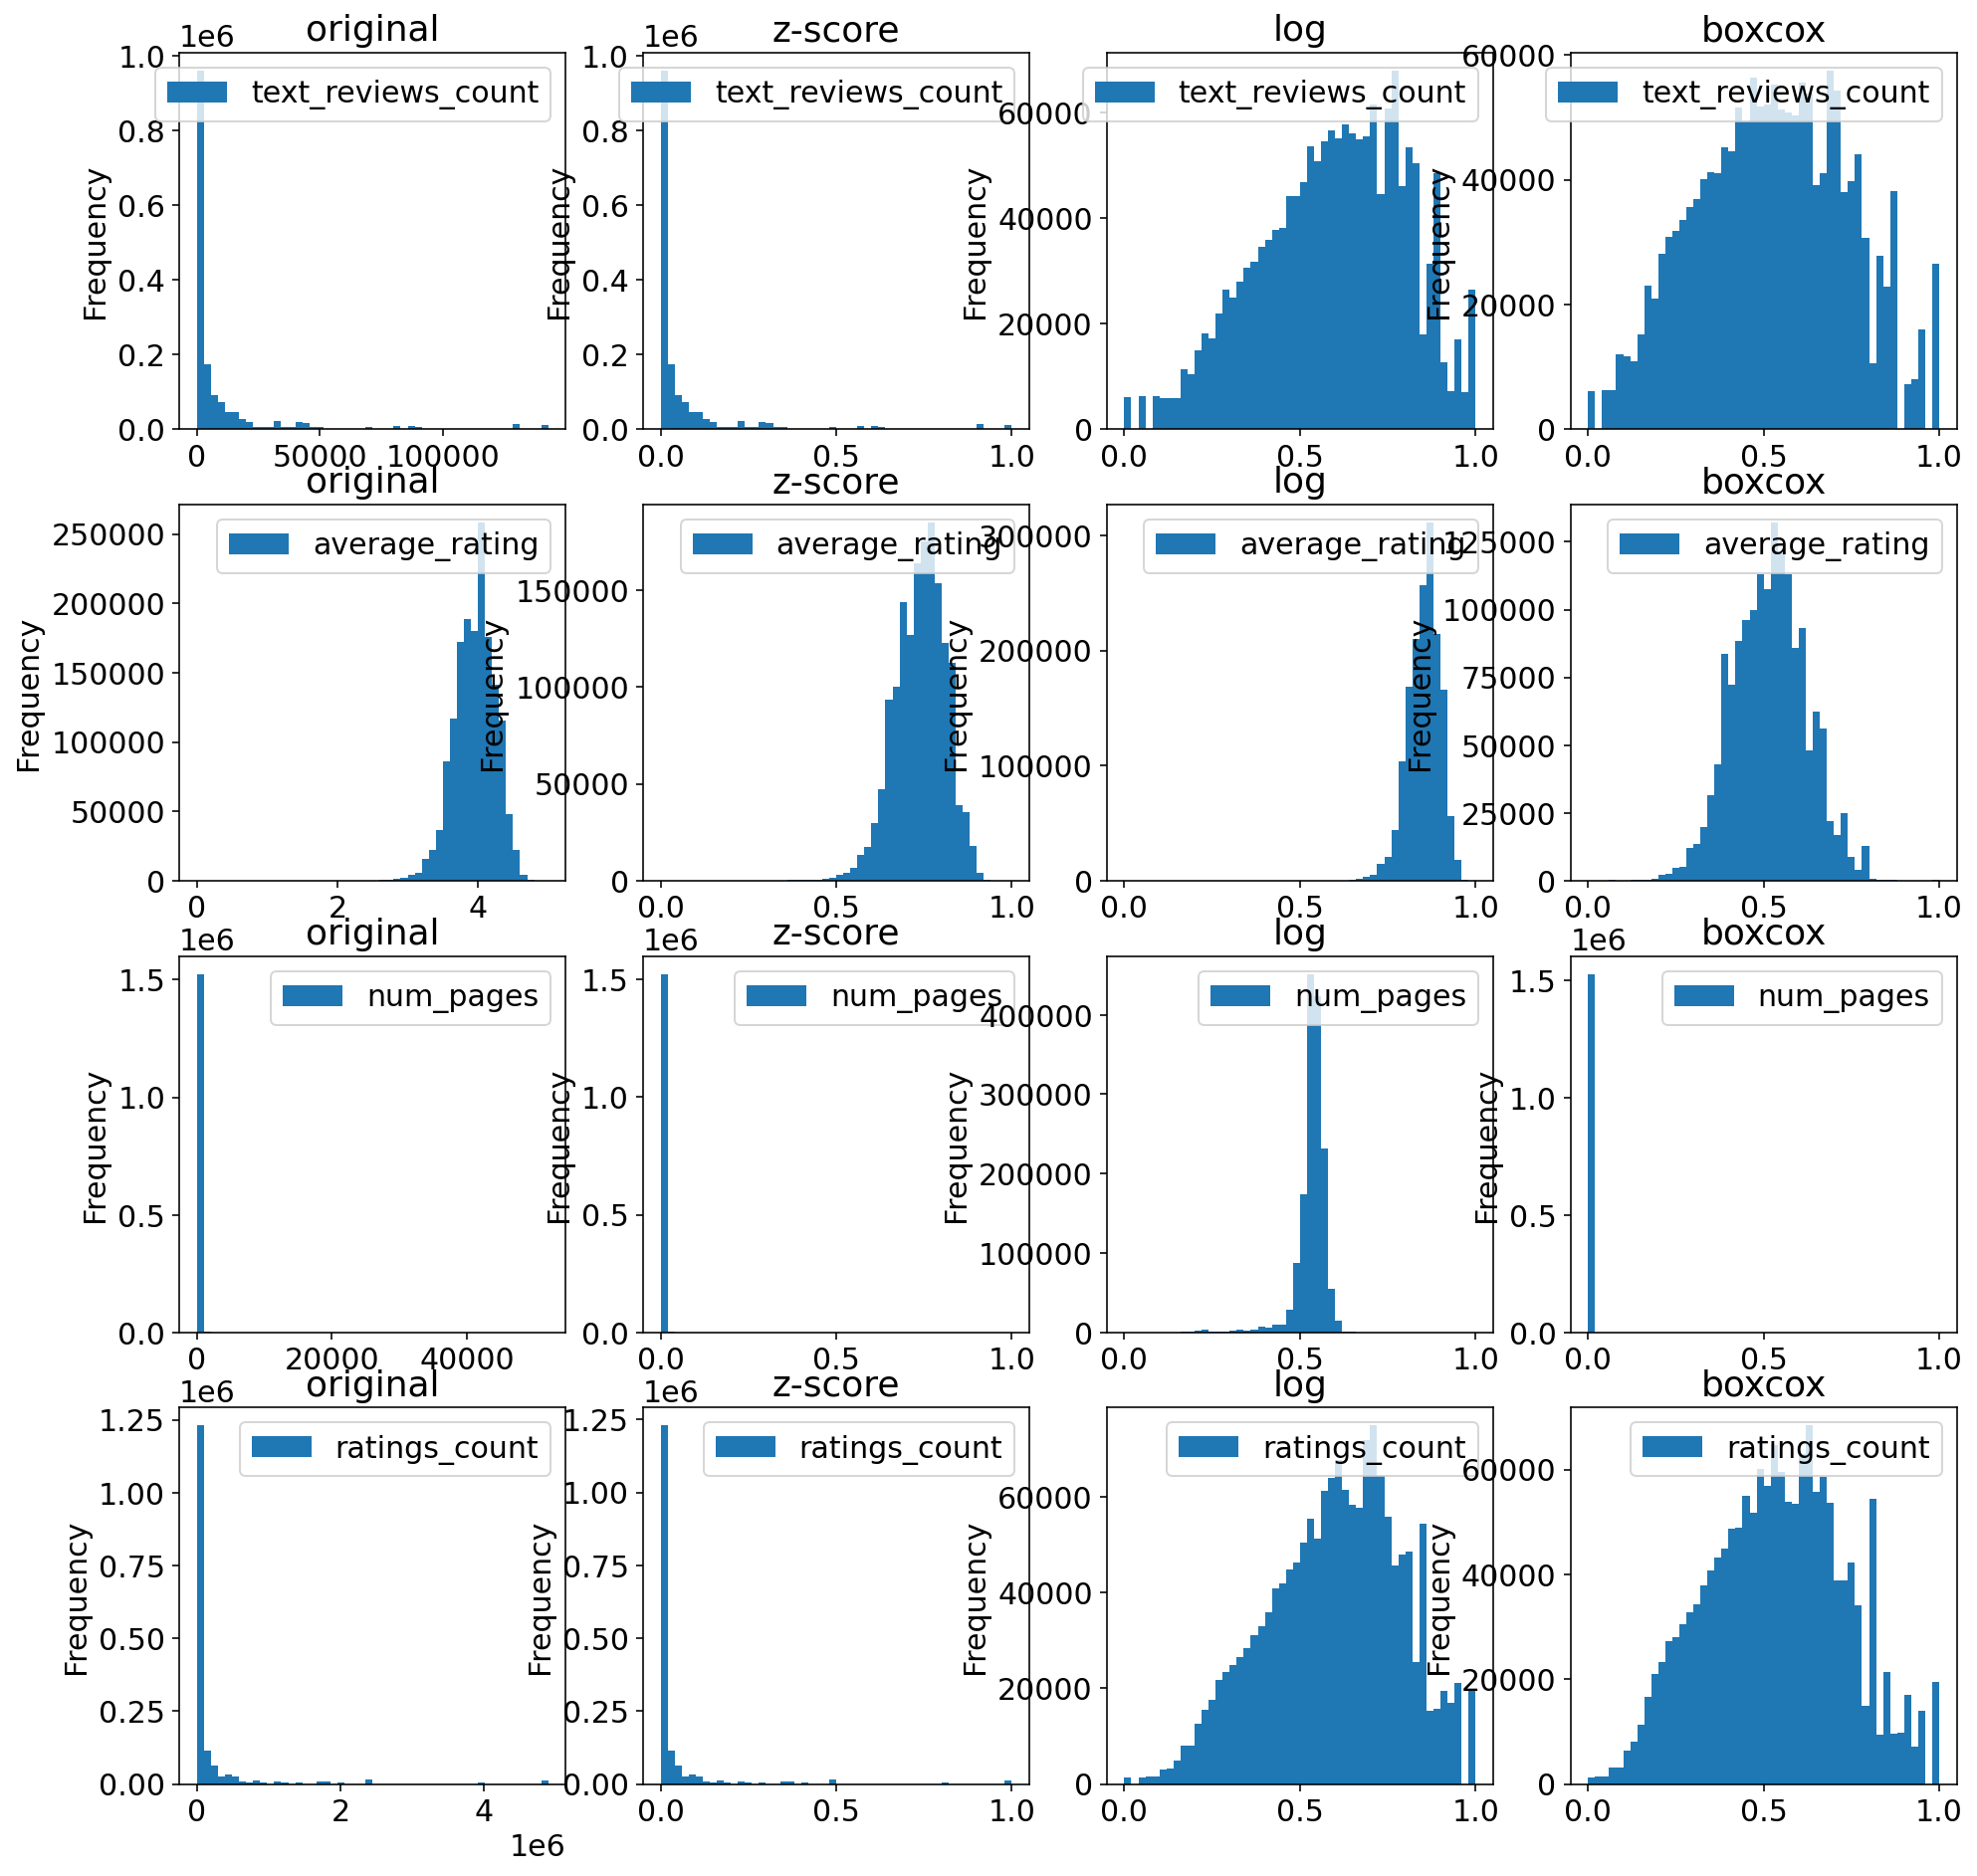

In [12]:
numeric_cols = [
                'text_reviews_count',
                'average_rating',
                'num_pages',
                'ratings_count'
               ]

scaler = MinMaxScaler(feature_range=(0,1))

def drop_zero(df, col_name):
    return [i != 0 for i in df[col_name]] 

ppl1 = Pipeline([
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('ZScore', pp.ZScoreNormalization(numeric_cols)),
     ('Scale', pp.Scale(numeric_cols, scaler)),
])
ppl2 = Pipeline([
# #      ('Scale', pp.Scale(numeric_cols, MinMaxScaler())),
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('Ln', pp.LogNormalization(numeric_cols)),
     ('Scale', pp.Scale(numeric_cols, scaler)),
])
ppl3 = Pipeline([
     ('DropZeros', pp.DropValues(numeric_cols, drop_zero)),
     ('Boxcox', pp.BoxCoxNormalization(numeric_cols)),
     ('Scale', pp.Scale(numeric_cols, scaler)),
])

titles = ['original', 'z-score', 'log', 'boxcox']


test_preprocessing(X_train, numeric_cols, [ppl1, ppl2, ppl3], titles=titles, kind='hist')

For skewed distributions work log and boxcox distribution pretty fine. We will use these approaches during the preprocessing

## Final pipeline

parameters setup:

In [13]:
drop_cols1 = ['isbn', 'series', 'country_code', 'language_code',
              'asin', 'kindle_asin',
              'description', 
              'format',
              'link',
              'is_ebook',
              'publisher',
              'publication_day', 'isbn13', 'publication_month',
              'edition_information',
              'publication_year', 'url', 'image_url',
              'title',
              'title_without_series',
              'date_added', 'date_updated', 'read_at', 'started_at',
              'n_votes',
              'n_comments'
             ]

replace_outliers_cols = ['text_reviews_count']

tags = ['favorites', 'currently-reading', 'to-read']

log_norm_cols = ['num_pages']
boxcox_norm_cols = ['text_reviews_count', 'average_rating', 'ratings_count']

scale_cols = log_norm_cols + boxcox_norm_cols

encoder = ce.OneHotEncoder()

drop_cols2 = ['popular_shelves', 'authors', 'similar_books', 
              'work_id', 'user_id', 'book_id', 'review_id', 'review_text']

scaler = MinMaxScaler(feature_range=(0,1))

def drop_zero(df, col_name):
    return [i != 0 for i in df[col_name]] 


Final pipeline:

In [16]:

ppl = Pipeline([
    ('DropUnusedCols1', pp.DropColumns(drop_cols1)),
    ('SelectTopNPercentileOfBooks', pp.SelectBooksWithNPercentile('text_reviews_count', 0.75)),
    ('DropOutliers', pp.DropOutliers(replace_outliers_cols)),
    ('DropZeros', pp.DropValues(scale_cols, drop_zero)),
    ('Ln', pp.LogNormalization(log_norm_cols)),
    ('Boxcox', pp.BoxCoxNormalization(boxcox_norm_cols)),
    ('Scale', pp.Scale(scale_cols, scaler)),
    ('ExportAuthorsAverageRating', pp.ExportAuthorsAverageRating('authors', 'authors_average_rating', authors)),
    ('ExportSimilarBooksAverageRating', pp.ExportSimilarBooksRating(
        books[['book_id','average_rating']], 'similar_books', 'sim_books_average_rating')),
    ('ExtraxtPopularShelves', pp.ExportBookShelves('popular_shelves', tags)),
    ('EmptyValuesFilter', pp.EmptyValuesFilter(['review_text'])),
    ('TextPreprocessor', pp.TextPreprocessor('review_text')),
    ('ReviewLengthFilter', pp.ReviewLengthFilter('review_text', 0, 2000)),
    ('ReviewsLanguageFilter', pp.ReviewsLanguageFilter('review_text', 'en')),
    ('DropUnusedCols2', pp.DropColumns(drop_cols2)),
#     ('EncodeCategories', pp.EncodeCategories(encoder))
])

model = ppl.fit(X_train[:100])

(fit) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(fit) Select books with: text_reviews_count >= 12215.5
(transform) Select books with: text_reviews_count >= 12215.5
-- Drop outliers for:  ['text_reviews_count']
(fit) LogNormalization
(transform) LogNormalization
(fit) LogNormalization

/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(fit) Export similar books average rating
(transform) Export similar books average rating
(fit) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(transform) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(fit) Empty values filter
(transform) Empty values filter
(fit) Text preprocessing
(transform) Text preprocessing
(fit) Review length filter
(transform) Review length filter
(fit) Reviews language filter
(transform) Reviews language filter
(fit) Drop columns: ['popular_shelves', 'authors', 'similar_books', 'work_id', 'user_id', 'book_id', 'review_id', 'review_text']


In [17]:
pX_train = ppl.transform(X_train[:100])

(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Select books with: text_reviews_count >= 12215.5
(transform) LogNormalization
(transform) LogNormalization
(transform) Scale cols: ['num_pages', 'text_reviews_count', 'average_rating', 'ratings_count']
(transform) Export authors average rating


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(transform) Export similar books average rating
(transform) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(transform) Empty values filter
(transform) Text preprocessing
(transform) Review length filter
(transform) Reviews language filter
(transform) Drop columns: ['popular_shelves', 'authors', 'similar_books', 'work_id', 'user_id', 'book_id', 'review_id', 'review_text']


In [18]:
pX_train.head()

,text_reviews_count,average_rating,num_pages,ratings_count,authors_average_rating,sim_books_average_rating,to-read,favorites,currently-reading
1703631,0.654432,0.563189,0.000000,0.702898,4.21,3.876667,427726,23667,15217
1700061,0.534762,0.000000,0.798252,0.790228,3.64,4.084444,1296,6604,6104
2334685,0.235382,0.153606,0.509245,0.462223,3.84,3.928889,1147,4223,0
2313973,1.000000,0.590902,0.609631,1.000000,4.09,4.142778,281,28751,29031
612566,0.509567,0.897149,0.290782,0.272551,4.42,4.203333,263587,6251,16522


In [19]:
y_train.loc[pX_train.index]

1703631    4
1700061    2
2334685    5
2313973    3
612566     5
616703     4
1613348    5
1876588    2
2189488    5
1595204    4
1630427    3
1705393    3
904139     5
1981184    5
2221384    3
1153000    5
1744273    4
2164731    2
2128121    4
906714     4
1938714    5
Name: rating, dtype: int64

In [20]:
pX_test = ppl.transform(X_test[:10])

(transform) Drop columns: ['isbn', 'series', 'country_code', 'language_code', 'asin', 'kindle_asin', 'description', 'format', 'link', 'is_ebook', 'publisher', 'publication_day', 'isbn13', 'publication_month', 'edition_information', 'publication_year', 'url', 'image_url', 'title', 'title_without_series', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments']
(transform) Select books with: text_reviews_count >= 12215.5
(transform) LogNormalization
(transform) LogNormalization
(transform) Scale cols: ['num_pages', 'text_reviews_count', 'average_rating', 'ratings_count']
(transform) Export authors average rating
(transform) Export similar books average rating
(transform) ExportBookShelves, tag_col: popular_shelves, tags:['favorites', 'currently-reading', 'to-read']
(transform) Empty values filter
(transform) Text preprocessing
(transform) Review length filter
(transform) Reviews language filter


/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/vajk/Documents/FIIT/8-semester/OZNAL/oznal-project/.venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(transform) Drop columns: ['popular_shelves', 'authors', 'similar_books', 'work_id', 'user_id', 'book_id', 'review_id', 'review_text']


In [21]:
pX_test

,text_reviews_count,average_rating,num_pages,ratings_count,authors_average_rating,sim_books_average_rating,to-read,currently-reading,favorites
1946889,0.592406,0.483033,0.445889,0.4504,4.24,3.985625,494863,583,11952


# Training

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
reg = LinearRegression().fit(pX_train, y_train[pX_train.index])

In [25]:
reg.score(pX_train, y_train[pX_train.index])

0.44181748599576165

In [26]:
reg.predict(pX_test)

array([4.4361891])